# Visualiztion of the audio perturbation pipeline

In [56]:
import torch

from data import AudioDataloader, MSPPodcast, MelTransform
from config import load_hydra_config
from models.content_encoder import XLSR_ESPEAK_CTC

cfg = load_hydra_config("vc_xlsr_ph.yaml", overrides=["data.dataset.segment_size=72000"])
dataloader = AudioDataloader(
    dataset=MSPPodcast(cfg.data, split="development"),
    cfg=cfg.data.dataloader,
    batch_size=1,
    shuffle=True,
)
encoder = XLSR_ESPEAK_CTC(return_logits=True, return_hidden=True)


In [57]:
x, n_frames, labels = next(iter(dataloader))

In [58]:
logits, hidden = encoder(x)
logits

tensor([[ 0,  0,  0,  0,  0,  0,  0, 41,  0,  0,  8,  0,  0,  0,  0,  6,  0,  7,
          0,  0,  0, 13,  0,  7,  0,  0,  6,  6,  8,  8,  0, 10,  0,  0,  0,  0,
          0,  0,  0, 22,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0, 22,  0,  7,  7,  0,  0,  0, 12,  0, 17,  0,  0,  0,
          0,  5,  0,  0, 37,  0,  0,  0,  0, 15,  0, 17,  0, 42,  0,  0,  0,  0,
         23,  0,  0, 36,  0,  0,  0,  0,  0, 11,  0,  0,  6,  0,  0,  0, 43,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 43,  0,  0,  0,
          0,  0,  0, 12,  0, 17,  0,  0,  0,  5,  0,  0, 37,  0,  0,  0,  0, 15,
          0, 17,  0,  0,  0, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         23,  0, 36,  0,  0,  0, 11,  0,  0,  6,  0, 43,  0,  0,  0, 22,  0,  0,
         36,  0,  0,  0,  6,

In [59]:
from IPython.display import Audio
Audio(x[0], rate=16000)

In [60]:
ph = encoder.processor.batch_decode(logits)
ph

['ɑː l t ə m ə t l i ð ə ð ə d ɪ s aɪ ɾ ɪ ŋ f æ k t ɚ ɚ d ɪ s aɪ ɾ ɪ ŋ f æ k t ɚ ð æ t']

In [61]:
def forward_fill(t: torch.Tensor) -> torch.Tensor:
    n_dim, t_dim = t.shape
    # Generate indices range
    rng = torch.arange(t_dim)

    rng_2d = rng.unsqueeze(0).repeat(n_dim, 1)
    # Replace indices to zero for elements that equal zero
    rng_2d[t == 0] = 0

    # Forward fill of indices range so all zero elements will be replaced with previous non-zero index.
    idx = rng_2d.cummax(1).values
    t = t[torch.arange(n_dim)[:, None], idx]
    return t

In [62]:
forward_fill(logits)

tensor([[ 0,  0,  0,  0,  0,  0,  0, 41, 41, 41,  8,  8,  8,  8,  8,  6,  6,  7,
          7,  7,  7, 13, 13,  7,  7,  7,  6,  6,  8,  8,  8, 10, 10, 10, 10, 10,
         10, 10, 10, 22, 22, 22,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7, 22, 22,  7,  7,  7,  7,  7, 12, 12, 17, 17, 17, 17,
         17,  5,  5,  5, 37, 37, 37, 37, 37, 15, 15, 17, 17, 42, 42, 42, 42, 42,
         23, 23, 23, 36, 36, 36, 36, 36, 36, 11, 11, 11,  6,  6,  6,  6, 43, 43,
         43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
         43, 43, 43, 12, 12, 17, 17, 17, 17,  5,  5,  5, 37, 37, 37, 37, 37, 15,
         15, 17, 17, 17, 17, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         23, 23, 36, 36, 36, 36, 11, 11, 11,  6,  6, 43, 43, 43, 43, 22, 22, 22,
         36, 36, 36, 36,  6,

In [63]:
encoder.processor.batch_decode(forward_fill(logits))

['ɑː l t ə m ə t l i ð ə ð ə d ɪ s aɪ ɾ ɪ ŋ f æ k t ɚ d ɪ s aɪ ɾ ɪ ŋ f æ k t ɚ ð æ t']

In [64]:
from data import MelTransform

mel_transform = MelTransform(cfg.data.mel_transform)

In [65]:
mel = mel_transform(x)

## Forward-filled phoneme prediction over Mel Spectrogram

C:\Users\alex_\AppData\Local\Temp\ipykernel_19964\833978531.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  norm = colors.BoundaryNorm(np.arange(logits_ff.min(), logits_ff.max() + 2), cmap.N)


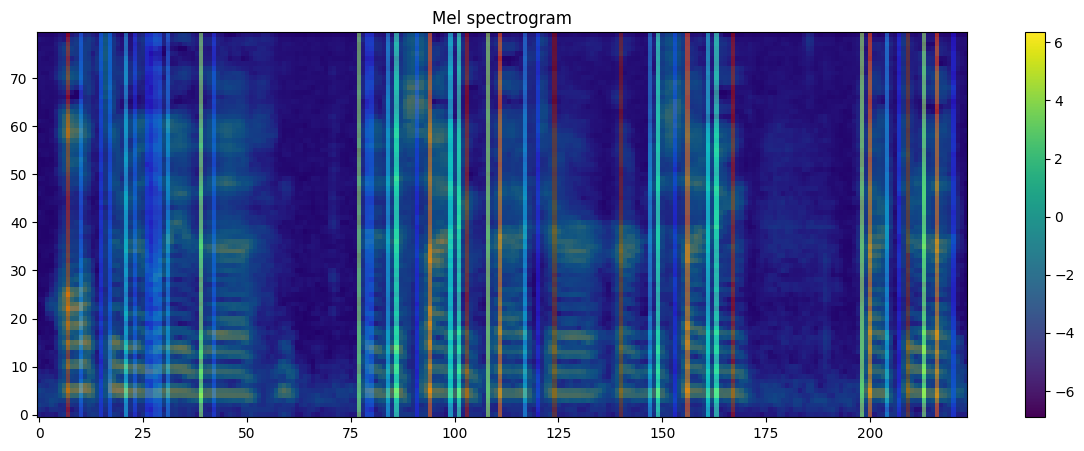

In [81]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

mel_ = mel[0].cpu().numpy()

cmap = plt.get_cmap('jet', len(logits_ff))
norm = colors.BoundaryNorm(np.arange(logits_ff.min(), logits_ff.max() + 2), cmap.N)

overlay = np.tile(logits, (mel_.shape[0], 1))

plt.figure(figsize=(15, 5))
plt.imshow(mel_, aspect="auto", origin="lower")
plt.colorbar()
plt.imshow(overlay, aspect="auto", origin="lower", cmap=cmap, norm=norm, alpha=0.5)
plt.title("Mel spectrogram")
plt.show()

## Phoneme-predictions without forward-fill

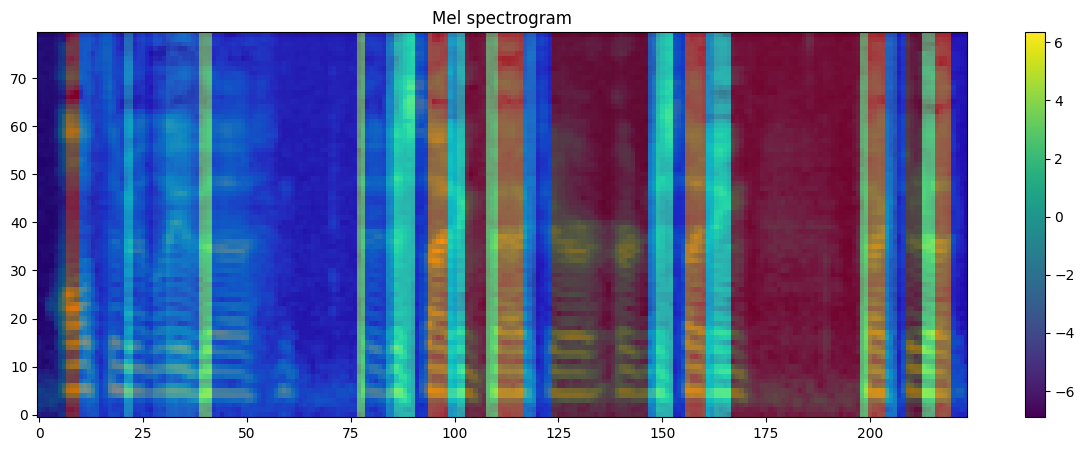

In [82]:
logits_ff = forward_fill(logits)[0]
overlay = np.tile(logits_ff, (mel_.shape[0], 1))

plt.figure(figsize=(15, 5))
plt.imshow(mel_, aspect="auto", origin="lower")
plt.colorbar()
plt.imshow(overlay, aspect="auto", origin="lower", cmap=cmap, norm=norm, alpha=0.5)
plt.title("Mel spectrogram")
plt.show()

## Phoneme-predictions with forward-fill and silence detection


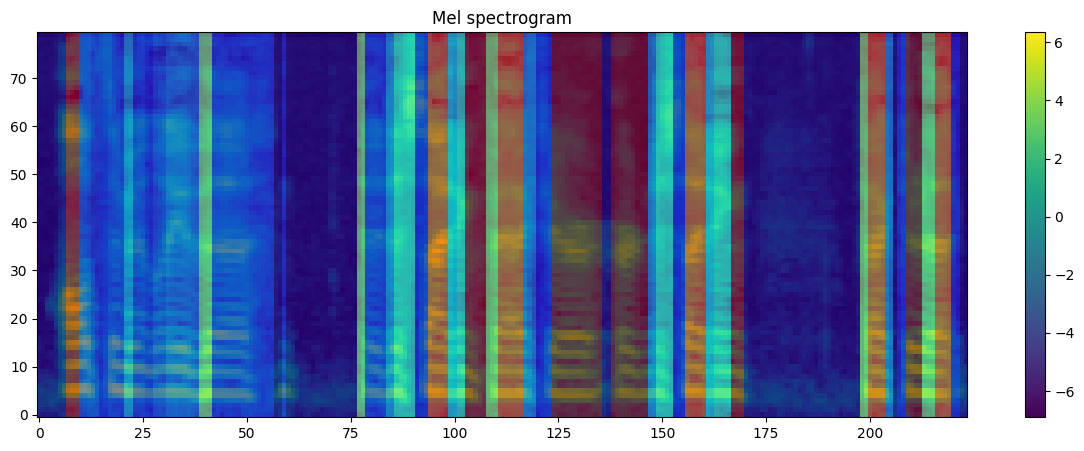

In [87]:
# set logits to zero where mel is under threshold
logits_ff_silence = logits_ff.clone()

silence_threshold = -4.5
logits_ff_silence[(mel_.mean(0) <= silence_threshold)[:-1]] = 0

overlay = np.tile(logits_ff_silence, (mel_.shape[0], 1))

plt.figure(figsize=(15, 5))
plt.imshow(mel_, aspect="auto", origin="lower")
plt.colorbar()
plt.imshow(overlay, aspect="auto", origin="lower", cmap=cmap, norm=norm, alpha=0.5)
plt.title("Mel spectrogram")
plt.show()

In [79]:
mel_.mean(0)

array([-5.8329334 , -5.871082  , -5.7001624 , -5.421684  , -4.4893794 ,
       -1.9547383 , -0.47927317, -0.14520568, -0.18730786, -0.25633317,
       -0.11296435, -0.12665796, -0.8279422 , -3.043367  , -4.28358   ,
       -2.5649128 , -1.3822571 , -0.5887774 , -0.61999595, -1.1016028 ,
       -1.7059    , -1.7778275 , -1.3417721 , -1.0991732 , -0.86793864,
       -1.0399415 , -1.7214    , -2.4986272 , -2.3578238 , -1.720376  ,
       -1.2450945 , -1.0219144 , -1.0097144 , -1.1464561 , -1.2092489 ,
       -1.0953745 , -1.5040376 , -2.645469  , -3.0820804 , -2.707045  ,
       -1.743071  , -1.0631171 , -0.7577379 , -0.6690365 , -0.58128077,
       -0.3828441 , -0.47074705, -0.57880956, -0.64498127, -0.6446091 ,
       -1.009177  , -1.9131572 , -2.546305  , -3.0074208 , -3.3755965 ,
       -3.7093856 , -4.018382  , -4.5039434 , -4.6094494 , -4.4228044 ,
       -4.5044026 , -5.0137377 , -5.590642  , -5.7885776 , -5.797162  ,
       -5.8163233 , -5.7994413 , -5.715853  , -5.7770476 , -5.82